# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [712]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
matplotlib.rcParams["backend"] = "TkAgg"
%matplotlib notebook
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [713]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [714]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [715]:
# What model to download.
MODEL_NAME = 'faster_rcnn'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('train_6', 'object-detection.pbtxt')
NUM_CLASSES=20

## Download Model

In [716]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [717]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [718]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [719]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [720]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'imagev{}.JPG'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [721]:
TEST_IMAGE_PATHS

['test_images/imagev1.JPG', 'test_images/imagev2.JPG']

In [722]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

816   612
[0.3169707  0.10678751 0.4297742  0.19133978]
87.13860833644867   193.98607206344604
[0.31343403 0.4631348  0.65859693 0.73032653]
377.91799306869507   191.8216291666031
0.99854666
0.9797816
2
coin
3
tomato
816   612
[0.52347344 0.13992399 0.6229294  0.21611486]
114.17797565460205   320.36574625968933
[0.37639824 0.48144957 0.6025595  0.6687931 ]
392.8628525733948   230.35572016239166
0.9984276
0.9785048
2
coin
3
tomato


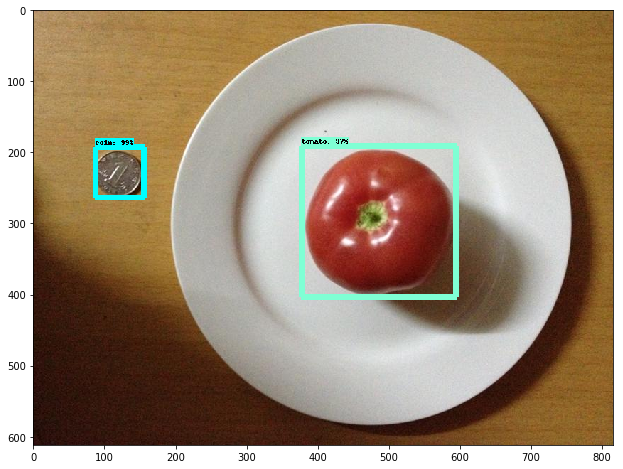

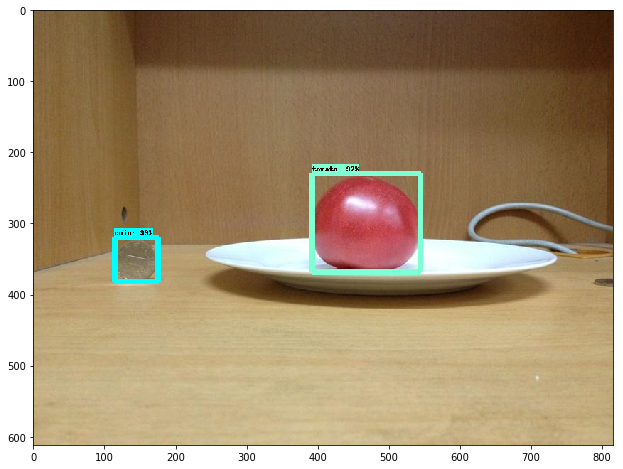

In [723]:
# 1st IMAGE TOP VIEW - 2nd IMAGE SIDE VIEW
import xlsxwriter 
workbook = xlsxwriter.Workbook('Info.xlsx') 

def label(numb):
    if(numb ==1):
        return 'apple'
    elif(numb==2):
        return 'coin'
    elif(numb==3):
        return 'tomato'
    elif(numb==4):
        return 'sachima'
    elif(numb==5):
        return 'bun'
    elif(numb==6):
        return 'orange'
    elif(numb==7):
        return 'banana'
    elif(numb==8):
        return 'pear'
    elif(numb==9):
        return 'fired dough twist'
    elif(numb==10):
        return 'doughnut'
    elif(numb==11):
        return 'peach'
    elif(numb==12):
        return 'plum'
    elif(numb==13):
        return 'mooncake'
    elif(numb==14):
        return 'lemon'
    elif(numb==15):
        return 'litchi'
    elif(numb==16):
        return 'qiwi'
    elif(numb==17):
        return 'grape'
    elif(numb==18):
        return 'bread'
    elif(numb==19):
        return 'egg'
    elif(numb==20):
        return 'mango'

 
def write_into_csv(output_dict,image_path):
    image_path= image_path[12:]
    worksheet = workbook.add_worksheet(image_path)   

    # Start from the first cell. 
    # Rows and columns are zero indexed. 
    row = 0
    column = 0
    worksheet.write(row, 0,"Object")
    worksheet.write(row, 1,"Score")
    worksheet.write(row, 2,"Box-x-min") 
    worksheet.write(row, 3,"Box-y-min")
    worksheet.write(row, 4,"Box-x-max") 
    worksheet.write(row, 5,"Box-y-max")
    worksheet.write(row, 6,"Object-Height") 
    worksheet.write(row, 7,"Object-Width")
    worksheet.write(row, 8,"Scale-Factor")
    worksheet.write(row, 9,"Pixels")
    worksheet.write(row, 10,"Volume S")
    
    width,height =image.size
    print(width," ",height)
    for k,v in output_dict.items():
        if(k=='detection_classes'):
            for i in v[:2]:
                print(i)
                print(label(i))
                worksheet.write(row+1, 0,label(i))
                row=row+1
        row=0
        if(k=='detection_scores'):
    #         print("Yeahbaby")
            for i in v:
                if(i>0.5):
                    print(i)
                    worksheet.write(row+1, 1,i)
                    row=row+1

        row=0
        if(k=='detection_boxes'):
            for i in v[:2]:
                print(i)
                print(i[1]*width, " ",i[0]*height)
                worksheet.write(row+1, 2,i[1]*width)
                worksheet.write(row+1, 3,i[0]*height)
                worksheet.write(row+1, 4,i[3]*width)
                worksheet.write(row+1, 5,i[2]*height)
                worksheet.write(row+1, 6,i[3]*width-i[1]*width)
                worksheet.write(row+1, 7,i[2]*height-i[0]*height)
                scale=(2.5/(((i[3]*width-i[1]*width)+(i[2]*height-i[0]*height))/2))
                worksheet.write(row+1, 8,scale)
                row=row+1
    #     print("key :{0} ,Value :{1}".format(k, v))


    #     if(output_dict['detection_scores']>0.5):
    #         print(output_dict['detection_boxes'] )
    #         print(output_dict['detection_classes'])
    #         print(output_dict['detection_scores'])

    # print(output_dict)


    
    
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    write_into_csv(output_dict,image_path)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    
workbook.close() 

In [724]:
# NOT USED
# import xlsxwriter module 
# # import xlsxwriter 
# # workbook = xlsxwriter.Workbook('Info.xlsx') 
# # worksheet = workbook.add_worksheet()   

# # # Start from the first cell. 
# # # Rows and columns are zero indexed. 
# # row = 0
# # column = 0
# # worksheet.write(row, 0,"Object")
# # worksheet.write(row, 1,"Score")
# # worksheet.write(row, 2,"Box-x-min") 
# # worksheet.write(row, 3,"Box-y-min")
# # worksheet.write(row, 4,"Box-x-max") 
# # worksheet.write(row, 5,"Box-y-max")
# # worksheet.write(row, 6,"Object-Height") 
# # worksheet.write(row, 7,"Object-Width")
# # worksheet.write(row, 8,"Scale-Factor")

# def label(numb):
#     if(numb ==1):
#         return 'apple'
#     elif(numb==2):
#         return 'coin'
    
# for image_path in TEST_IMAGE_PATHS:
#     image = Image.open(image_path)
#     width,height =image.size
#     print(width," ",height)
#     output_dict = run_inference_for_single_image(image_np, detection_graph)
# #     print(output_dict)
#     for k,v in output_dict.items():
#         if(k=='detection_classes'):
#             for i in v[:2]:
#                 print(i)
#                 print(label(i))
# #                 worksheet.write(row+1, 0,label(i))
# #                 row=row+1
# #         row=0
#         if(k=='detection_scores'):
#     #         print("Yeahbaby")
#             for i in v:
#                 if(i>0.5):
#                     print(i)
# #                     worksheet.write(row+1, 1,i)
# #                     row=row+1

# #         row=0
# #         if(k=='detection_boxes'):
# #             for i,j in v[:2]:
# #                 print(i)
# #                 print(i[1]*width, " ",i[0]*height)
# #                 worksheet.write(row+1, 2,i[1]*width)
# #                 worksheet.write(row+1, 3,i[0]*height)
# #                 worksheet.write(row+1, 4,i[3]*width)
# #                 worksheet.write(row+1, 5,i[2]*height)
# #                 worksheet.write(row+1, 6,i[3]*width-i[1]*width)
# #                 worksheet.write(row+1, 7,i[2]*height-i[0]*height)
# #                 scale=(2.5/(((i[3]*width-i[1]*width)+(i[2]*height-i[0]*height))/2))
# #                 worksheet.write(row+1, 8,scale)
# #                 row=row+1
#     #     print("key :{0} ,Value :{1}".format(k, v))


#     #     if(output_dict['detection_scores']>0.5):
#     #         print(output_dict['detection_boxes'] )
#     #         print(output_dict['detection_classes'])
#     #         print(output_dict['detection_scores'])

#     # print(output_dict)






# # workbook.close() 

In [725]:
# Not USED

# # import xlsxwriter module 
# import xlsxwriter 
# workbook = xlsxwriter.Workbook('Info.xlsx') 
# worksheet = workbook.add_worksheet()   

# # Start from the first cell. 
# # Rows and columns are zero indexed. 
# row = 0
# column = 0
# worksheet.write(row, 0,"Object")
# worksheet.write(row, 1,"Score")
# worksheet.write(row, 2,"Box-x-min") 
# worksheet.write(row, 3,"Box-y-min")
# worksheet.write(row, 4,"Box-x-max") 
# worksheet.write(row, 5,"Box-y-max")
# worksheet.write(row, 6,"Object-Height") 
# worksheet.write(row, 7,"Object-Width")
# worksheet.write(row, 8,"Scale-Factor")

# def label(numb):
#     if(numb ==1):
#         return 'apple'
#     elif(numb==2):
#         return 'coin'
# def write_into_csv(output_dict):    
#     width,height =image.size
#     print(width," ",height)
#     for k,v in output_dict.items():
#         if(k=='detection_classes'):
#             for i in v[:2]:
#                 print(i)
#                 print(label(i))
#                 worksheet.write(row+1, 0,label(i))
#                 row=row+1
#         row=0
#         if(k=='detection_scores'):
#     #         print("Yeahbaby")
#             for i in v:
#                 if(i>0.5):
#                     print(i)
#                     worksheet.write(row+1, 1,i)
#                     row=row+1

#         row=0
#         if(k=='detection_boxes'):
#             for i,j in v[:2]:
#                 print(i)
#                 print(i[1]*width, " ",i[0]*height)
#                 worksheet.write(row+1, 2,i[1]*width)
#                 worksheet.write(row+1, 3,i[0]*height)
#                 worksheet.write(row+1, 4,i[3]*width)
#                 worksheet.write(row+1, 5,i[2]*height)
#                 worksheet.write(row+1, 6,i[3]*width-i[1]*width)
#                 worksheet.write(row+1, 7,i[2]*height-i[0]*height)
#                 scale=(2.5/(((i[3]*width-i[1]*width)+(i[2]*height-i[0]*height))/2))
#                 worksheet.write(row+1, 8,scale)
#                 row=row+1
#     #     print("key :{0} ,Value :{1}".format(k, v))


#     #     if(output_dict['detection_scores']>0.5):
#     #         print(output_dict['detection_boxes'] )
#     #         print(output_dict['detection_classes'])
#     #         print(output_dict['detection_scores'])

#     # print(output_dict)






# workbook.close() 

In [726]:
width,height =image.size
for x in range(2):
#     print(output_dict['detection_boxes'][x][0])
    ymin =output_dict['detection_boxes'][x][0]*height
    xmin =output_dict['detection_boxes'][x][1]*width
    ymax =output_dict['detection_boxes'][x][2]*height
    xmax =output_dict['detection_boxes'][x][3]*width
    object_height = xmax-xmin
    object_width = ymax-ymin
    # print(xmin,ymin)
    # print(xmax,ymax)
    print(object_height)
    print(object_width)
    scale_factor = 2.5/((object_height+object_width)/2)
    print( "Scale Factor ",scale_factor )
    print("object_height ",object_height*scale_factor)
    print("object_width ",object_width*scale_factor)
    if(object_height*scale_factor >3):
        height_fin=object_height*scale_factor
    elif(object_width*scale_factor >3):
        width_fin=object_width*scale_factor     
# if(height_fin):print(height_fin)
# if(width_fin):print(width_fin)

62.17175316810608
60.867043018341064
Scale Factor  0.04063758875227646
object_height  2.5265101372535357
object_width  2.4734898627464643
152.87230253219604
138.410698056221
Scale Factor  0.01716543701451703
object_height  2.6241198803806034
object_width  2.375880119619396


In [727]:
print(0.04039338891627074 *257.3298282623291)
print(64.25131165981293 *0.04039338891627074 )
print(0.04039338891627074 *231.85786771774292)


10.394423832757418
2.5953282202553445
9.365525024020044


In [728]:
# for image_path in TEST_IMAGE_PATHS:
#     image = Image.open(image_path)
#     print(image_path)
#     width, height = image.size
#     print(width, height)
#     boxes =detection_graph.get_tensor_by_name('detection_boxes:0')
#     print(boxes)
#     ymin = boxes[0][1][0]*height
#     xmin = boxes[0][1][1]*width
#     ymax = boxes[0][1][2]*height
#     xmax = boxes[0][1][3]*width

#     print ('Top left')
#     print (xmin,ymin,)
#     print ('Bottom right')
#     print (xmax,ymax)
    
#     ymin = boxes[0][2][0]*height
#     xmin = boxes[0][2][1]*width
#     ymax = boxes[0][2][2]*height
#     xmax = boxes[0][2][3]*width

#     print ('Top left')
#     print (xmin,ymin,)
#     print ('Bottom right')
#     print (xmax,ymax)
# #     cropped_image = tf.image.crop_to_bounding_box(image, ymin, xmin, ymax - ymin, xmax - xmin)
    

In [729]:

# print(detection_graph.get_operations())

predict  tomato row1  2
Density (g/cm^3)  0.98
Energy (kcal/g)  0.27
shape  ellipsoid


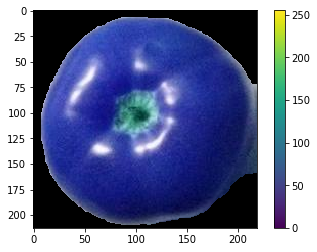

predict  tomato row1  2
Density (g/cm^3)  0.98
Energy (kcal/g)  0.27
shape  ellipsoid
changed  0.04063758875227646
Volume  115.94118143089933
mass  113.62235780228134 calories  30.678036606615965


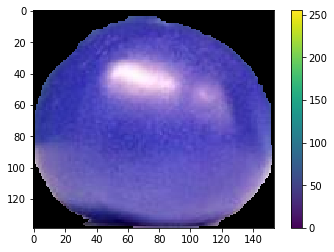

In [730]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import xlrd
from PIL import Image
loc="Info.xlsx" 
import math

import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
 
df = pd.read_excel('energy.xlsx', sheet_name='Sheet1')

from openpyxl import Workbook
from openpyxl import load_workbook
row1=1
wb_write=load_workbook("Info.xlsx")

for image_path in TEST_IMAGE_PATHS:

    image = Image.open(image_path)
    sheet_name= image_path[12:]
    wb_write.sheetnames
    sheet_write=wb_write[sheet_name]
    wb = xlrd.open_workbook(loc) 
    sheet = wb.sheet_by_name(sheet_name)
    sheet_top= wb.sheet_by_name("imagev1.JPG")
    sheet_write_top=wb_write["imagev1.JPG"]
    sheet_side= wb.sheet_by_name("imagev2.JPG")
#     sheet_write=wb_write.get_sheet_by_name(sheet_name)
# sswdwa
#     print(sheet.cell_value(1, 0))
    if(sheet.cell_value(1, 0) !='coin'):
        predict=sheet.cell_value(1, 0)
    else:
        predict=sheet.cell_value(2, 0)
        row1=2
        print("predict ",predict , "row1 ",row1)
 
    croprect=(int(sheet.cell_value(row1, 2))-1,int(sheet.cell_value(row1, 3))-1,int(sheet.cell_value(row1, 4)),int(sheet.cell_value(row1, 5)))
    cropped_image = image.crop(croprect)
    
    
    cropped_image.save(sheet_name)
    img = cv2.imread(sheet_name)
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (1,1,int(sheet.cell_value(row1, 6)),int(sheet.cell_value(row1, 7)))

    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]

    

    for i in df.index:
    #     print(df['Unnamed: 1'][i])
        if(predict ==df['Unnamed: 1'][i]):
            density =df['Density (g/cm^3)'][i]
            print("Density (g/cm^3) ", df['Density (g/cm^3)'][i])
            energy =df['Energy (kcal/g)'][i]
            print("Energy (kcal/g) ",df['Energy (kcal/g)'][i])
            print("shape ",df['shape'][i])
            if(df['shape'][i] == 'ellipsoid'):
                if(sheet_name =='imagev2.JPG'):
                    if(sheet.cell_value(1, 0) =='coin'):
                        scale_factor_coin=sheet.cell_value(1, 8)
                        print("changed ",scale_factor_coin)
                    else:
                        scale_factor_coin=sheet.cell_value(2, 8)
#                         print(scale_factor_coin)
#                         print("row1 change")
                    count=0
                    square=0
                    list_img =np.array(list(img))
                    #     print(list_img.shape)
                    for i in range(list_img.shape[0]):
                        count=0
                        for j in range(list_img.shape[1]):
                            if(list_img[i][j][0] !=0 or list_img[i][j][1] !=0 or list_img[i][j][2] !=0):
                                count+=1
#                         print("count ",count ,"square " ,square)
                        square=square+(count*count)
                        #         print(square)
                    
                    sheet_write.cell(row=row1, column=10).value = square
                    volume =square*math.pow(scale_factor_coin ,3)*(math.pi/4)
                    sheet_write.cell(row=row1, column=11).value = volume
                    mass=volume*density
                    calories=mass*energy
                    print("Volume " ,volume)
                    print("mass ",mass,"calories ",calories)
                    wb_write.save("Info.xlsx")
            elif(df['shape'][i] == 'irregular'):
                max_pix=0
                count=0
                square=0
                count_max=0
                list_img =np.array(list(img))
                #     print(list_img.shape)
#                 Two loops for calculating max pixel in all rows 
                print("Sheet name - ",sheet_name)
                print("row - ",row1)
                if(sheet_name =='imagev1.JPG'):
                    count_top=0
                    for i in range(list_img.shape[0]):
                        for j in range(list_img.shape[1]):
                            if(list_img[i][j][0] !=0 or list_img[i][j][1] !=0 or list_img[i][j][2] !=0):
                                count_top+=1
#                         print(count_top)
                    count_top=count_top
                    print("Numbr of pixels in top view ",count_top)
                    if(sheet.cell_value(1, 0) =='coin'):
                        scale_factor_top=sheet.cell_value(1, 8)
                        print("scale_factor_top ",scale_factor_top)
                    else:
                        scale_factor_top=sheet.cell_value(2, 8)
                        print("scale_factor_top ",scale_factor_top)
                else:
                    if(sheet.cell_value(1, 0) =='coin'):
                        scale_factor_side=sheet.cell_value(1, 8)
                        print("scale_factor_side ",scale_factor_side)
                    else:
                        scale_factor_side=sheet.cell_value(2, 8)
                        print("scale_factor_side ",scale_factor_side)
                    for i in range(list_img.shape[0]):
#                         print(count_max)
                        if(count_max>max_pix):
                            max_pix=count_max
#                             print("max_pix Changed ", max_pix)
                        count_max=0
                        for j in range(list_img.shape[1]):
                            if(list_img[i][j][0] !=0 or list_img[i][j][1] !=0 or list_img[i][j][2] !=0):
                                count_max+=1

                    for i in range(list_img.shape[0]):
#                         print(count)
                        count=0
                        for j in range(list_img.shape[1]):
                            if(list_img[i][j][0] !=0 or list_img[i][j][1] !=0 or list_img[i][j][2] !=0):
                                count+=1
                        square=square+((count*count)/(max_pix*max_pix))
                        #         print(square)
                    print("Numbr of pixels in top view ",count_top)
                    print("Scale Factor Top coin " ,scale_factor_top)
                    sheet_write.cell(row=row1, column=10).value = square
                    volume =(count_top*math.pow(scale_factor_top,2)*square*scale_factor_side)
                    print("Volume cm^3",volume)
                    mass=volume*density
                    calories=mass*energy
                    print("mass in g ",mass,"calories in kCal/g",calories)
                    sheet_write.cell(row=row1, column=11).value = volume
                    wb_write.save("Info.xlsx")
                    
    #                 volume= (3.14)*(width_fin)*(height_fin/2)*(height_fin/2)
            elif(df['shape'][i] == 'column'):
                max_pix=0
                count=0
                square=0
                count_max=0
                
                H=0
                list_img =np.array(list(img))
                #     print(list_img.shape)
#                 Two loops for calculating max pixel in all rows 
                print("Sheet name - ",sheet_name)
                print("row - ",row1)
                if(sheet_name =='imagev1.JPG'):
                    count_top=0
                    for i in range(list_img.shape[0]):
                        for j in range(list_img.shape[1]):
                            if(list_img[i][j][0] !=0 or list_img[i][j][1] !=0 or list_img[i][j][2] !=0):
                                count_top+=1
#                         print(count_top)
                    count_top=count_top
                    print("Numbr of pixels in top view ",count_top)
                    if(sheet.cell_value(1, 0) =='coin'):
                        scale_factor_top=sheet.cell_value(1, 8)
                        print("scale_factor_top ",scale_factor_top)
                    else:
                        scale_factor_top=sheet.cell_value(2, 8)
                        print("scale_factor_top ",scale_factor_top)
                else:
                    if(sheet.cell_value(1, 0) =='coin'):
                        scale_factor_side=sheet.cell_value(1, 8)
                        print("scale_factor_side ",scale_factor_side)
                    else:
                        scale_factor_side=sheet.cell_value(2, 8)
                        print("scale_factor_side ",scale_factor_side)
                    
                    for i in range(list_img.shape[0]):
                        H=H+1
                        #         print(square)
                    print("Numbr of Rows in SideView ",H)
                    print("Numbr of pixels in top view ",count_top)
                    print("Scale Factor Top coin " ,scale_factor_top)
#                     sheet_write.cell(row=row1, column=10).value = square
                    volume =(count_top*math.pow(scale_factor_top,2)*H*scale_factor_side)
                    print("Volume cm^3",volume)
                    mass=volume*density
                    calories=mass*energy
                    print("mass in g ",mass,"calories in kCal/g",calories)
                    sheet_write.cell(row=row1, column=11).value = volume
                    wb_write.save("Info.xlsx")

    

    plt.imshow(img)
    plt.colorbar()
    plt.show()
   


In [731]:
# import numpy as np
# import cv2
# from matplotlib import pyplot as plt
# import xlrd
# loc="Info.xlsx"    
# for image_path in TEST_IMAGE_PATHS:
#     image = Image.open(image_path)
#     sheet_name= image_path[12:]
    
#     wb = xlrd.open_workbook(loc) 
#     sheet = wb.sheet_by_name(sheet_name) 
    
#     img = cv2.imread(sheet_name)
#     mask = np.zeros(img.shape[:2],np.uint8)

#     bgdModel = np.zeros((1,65),np.float64)
#     fgdModel = np.zeros((1,65),np.float64)

#     rect = (1,1,int(sheet.cell_value(1, 6)),int(sheet.cell_value(1, 7)))

#     cv2.grabCut(img,mask,rect,bgdModel,fgdModel,15,cv2.GC_INIT_WITH_RECT)
#     mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#     img = img*mask2[:,:,np.newaxis]

#     plt.imshow(img)
#     plt.colorbar()
#     plt.show()

In [732]:
# import pandas as pd
# from pandas import ExcelWriter
# from pandas import ExcelFile
 
# df = pd.read_excel('energy.xlsx', sheet_name='Sheet1')
 
# print("Column headings:")
# print(df.columns)
# # print(df['Unnamed: 1'])
# width_fin=10
# height_fin=9
# predict=sheet.cell_value(2,0 )
# for i in df.index:
# #     print(df['Unnamed: 1'][i])
#     if(predict ==df['Unnamed: 1'][i]):
#         print(df['Density (g/cm^3)'][i])
#         print(df['Energy (kcal/g)'][i])
#         print(df['shape'][i])
#         if(df['shape'][i] == 'ellipsoid'):
#             volume= (4/3)*3.14*(width_fin/2)*(height_fin/2)*(width_fin/2)
#         elif(df['shape'][i] == 'irregular'):
#             volume= (3.14)*(width_fin)*(height_fin/2)*(height_fin/2)
#         elif(df['shape'][i] == 'column'):
#             volume=height_fin*height_fin*width_fin
#         mass=volume*df['Density (g/cm^3)'][i]
#         calories=mass*df['Energy (kcal/g)'][i]
#         print(calories)
            

In [733]:
import matplotlib
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

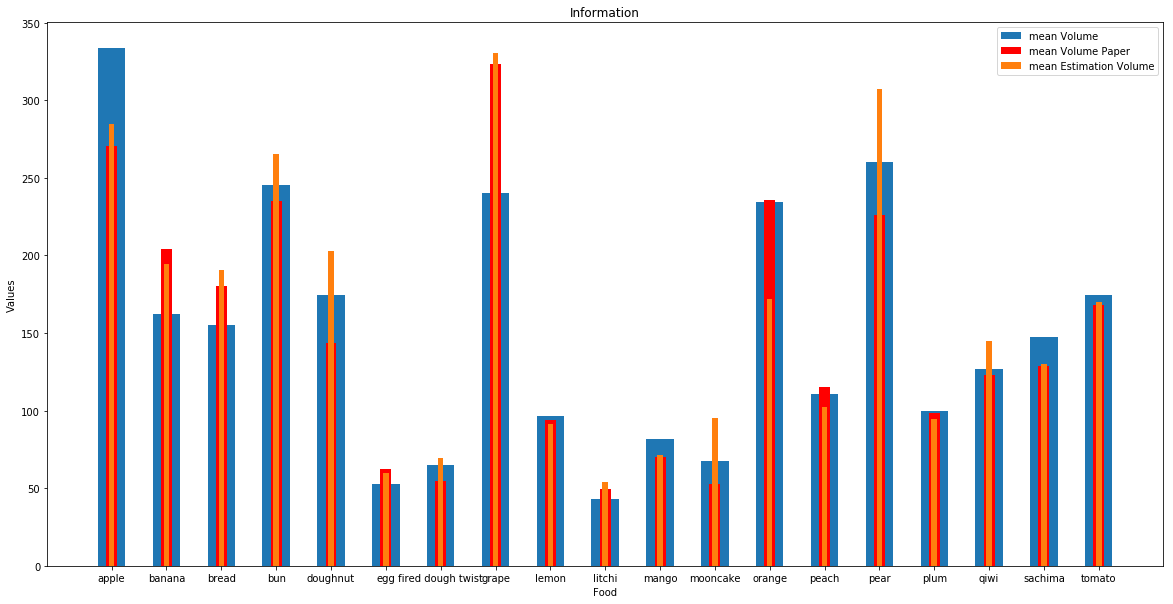

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10)) 
    
LABELS = ["apple","banana","bread","bun","doughnut","egg","fired dough twist","grape","lemon","litchi","mango","mooncake","orange"
,"peach","pear","plum","qiwi","sachima","tomato"]   

number =[
    
    
    
    
    
    
    
    
    
    94.32,190.36,265.46,202.73,60,69.6,330.6,91.26,54.24,71.3,95.23,172.099,102.138,307,94.5,145,
130.23,170]
plt.bar(number,mean_volume,label="mean Volume",width=.5 )
plt.bar(number,mean_volume_paper,label="mean Volume Paper", color='r',width=.2)
plt.bar(number,mean_estimation_vol,label="mean Estimation Volume",width=.1)

plt.legend()
plt.xticks(number, LABELS)
plt.xlabel('Food')
plt.ylabel('Values')
plt.title('Information')
plt.show()
